<a href="https://colab.research.google.com/github/shizuo-kaji/CubicalRipser_3dim/blob/master/demo/cubicalripser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of Cubical Ripser

You may also want to look at [A guide through TDA tools](https://colab.research.google.com/github/shizuo-kaji/TutorialTopologicalDataAnalysis/blob/master/TopologicalDataAnalysisWithPython.ipynb) giving a hands-on tutorial for various tools for topological data analysis including Cubical Ripser

## Installation of necessary libraries

In [ ]:
## If you do not have the necessary libraries installed, run this cell (only for once)
## Be patient! It takes time.
# for standard libraries such as numpy, scipy, scikit-learn
# I recommend to use the package manager "conda". e.g.,  "conda install numpy scipy scikit-learn"
!pip install matplotlib Pillow pooch gudhi
!pip install -U -q cripser
#!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim

## minimal example

['PH0:13806', 'PH1:9292']


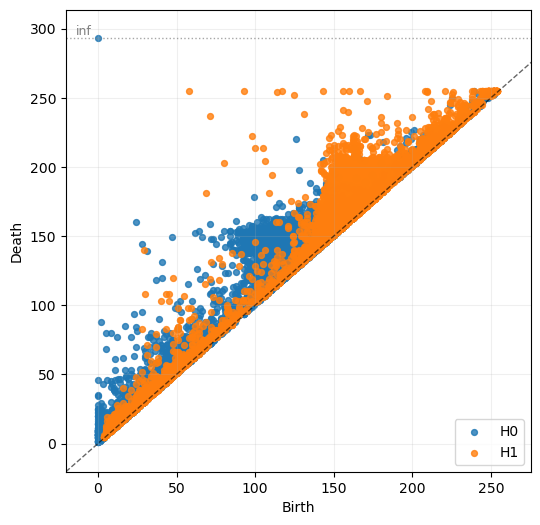

In [1]:
import numpy,cripser
from PIL import Image

img = numpy.array(Image.open("img.jpg").convert('L'))
pd = cripser.compute_ph(img)
print([f'PH{i}:{len(x)}' for i, x in enumerate(cripser.group_by_dim(pd))])
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pd))


## Load libraries

In [3]:
## load necessary libraries
%matplotlib inline
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob
from PIL import Image
import cripser
import skimage
from skimage import io
from skimage.transform import rotate
from skimage.data import cells3d
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt,convolve
import os, re

cripser.__version__

'0.0.22'

In [4]:
# make binary and apply distance transform
def dt(img,radius=15,signed=False):
#    bw_img = (img >= rank.otsu(img, disk(radius)))
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)
    if signed:
        dt_img -= distance_transform_edt(~bw_img)
    return(dt_img)

def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = data.shape[-1]
    @interact(plane=(0, N - 1))
    def display_slice(plane=N//2):
        fig, ax = plt.subplots(figsize=(20, 5))
        plt.imshow(data[:,:,plane],cmap=cmap)
        plt.show()
    return display_slice


## Persistence diagram

### 2D image

(512, 512) uint8 0--255


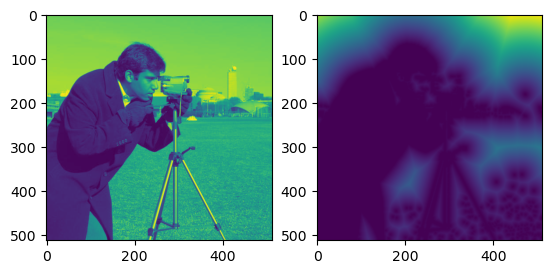

In [4]:
## set the following appropriately
imgfile = "img.jpg"  ## image file name for a 2D example

# load image data
if os.path.isfile(imgfile):
    img2d = np.array(Image.open(imgfile).convert('L'))
else: # if file is not found, load the demo img from skimage
    img2d = skimage.data.camera()
    io.imsave(imgfile, img2d)

#img2d = skimage.transform.resize(img2d,(300,400))

## apply distance transform
img2d_dt = dt(img2d)

fig,axs = plt.subplots(1,2)
axs[0].imshow(img2d)
axs[1].imshow(img2d_dt)
print(img2d.shape, img2d.dtype, f"{np.min(img2d)}--{np.max(img2d)}")


Betti numbers (V):  [13806, 9292]
Betti numbers (T):  [9579, 13530]
elapsed_time:0.28951120376586914 sec


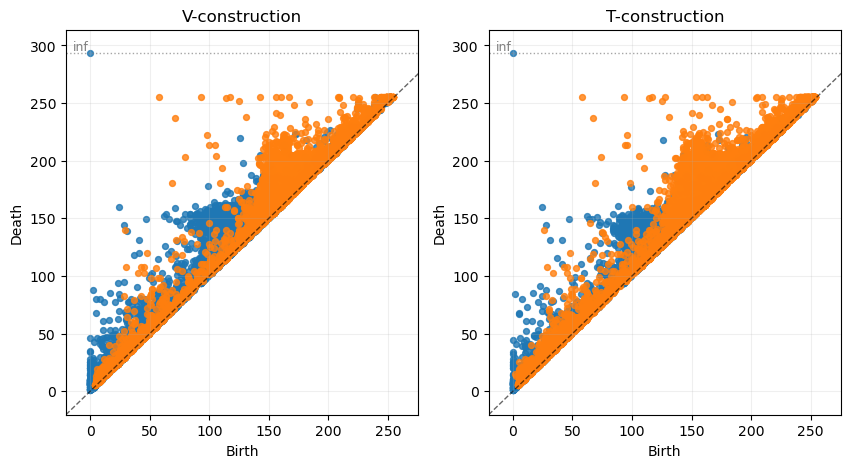

In [11]:
# 2D: compute PH for the V-construction of the original image (pixel value filtration)

start = time.time()
pd = cripser.compute_ph(img2d)
pds = cripser.group_by_dim(pd)
print("Betti numbers (V): ",[len(pds[i]) for i in range(len(pds))])

# compute PH for the T-construction of the original image (pixel value filtration)
pdt = cripser.compute_ph(img2d, filtration="T")
pdst = cripser.group_by_dim(pdt)
print("Betti numbers (T): ",[len(pdst[i]) for i in range(len(pdst))])

print ("elapsed_time:{} sec".format(time.time() - start))
## plot persistent diagram
fig,axs = plt.subplots(1,2, figsize=(10,5))
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pd), ax=axs[0], title='V-construction')
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pdt), ax=axs[1], title='T-construction')


In [6]:
img2d.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [7]:
# compute PH for the T-construction by GUDHI
try:
    import gudhi
    start = time.time()
    gd = gudhi.CubicalComplex(vertices=img2d)
    #    gd.compute_persistence()
    res = gd.persistence(2,0) # coeff = 2
    print("Betti numbers (V): ", gd.persistent_betti_numbers(np.inf,-np.inf))
    gd = gudhi.CubicalComplex(top_dimensional_cells=img2d)
    res = gd.persistence(2,0) # coeff = 2
    print("Betti numbers (T): ", gd.persistent_betti_numbers(np.inf,-np.inf))
    print ("elapsed_time:{} sec".format(time.time() - start))
except ImportError:
    print("GUDHI is not installed.")


Betti numbers (V):  [13806, 9292, 0]
Betti numbers (T):  [9579, 13530, 0]
elapsed_time:0.6548058986663818 sec


Betti numbers:  [297, 406]
Betti numbers:  [261, 885]
elapsed_time:0.19816207885742188 sec


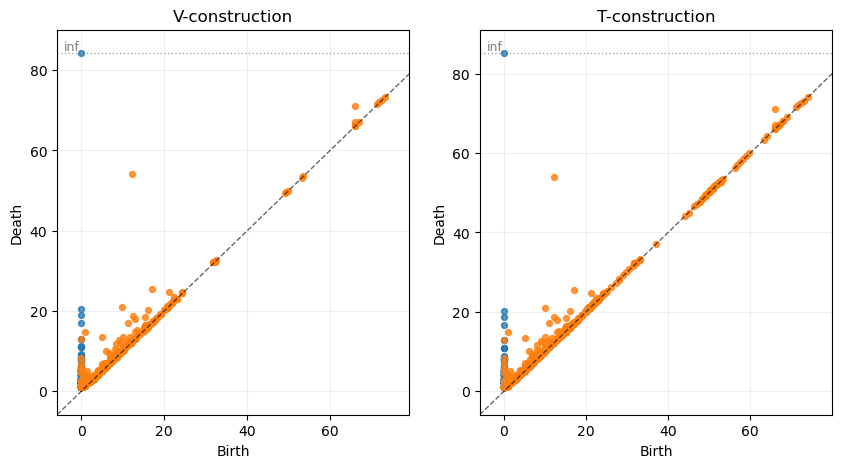

In [12]:
# 2D: compute PH for the V-construction of the distance transformed image
start = time.time()
pd = cripser.compute_ph(img2d_dt)
pds = cripser.group_by_dim(pd)
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# compute PH for the T-construction of the distance transformed image
pdt = cripser.compute_ph(img2d_dt, filtration="T")
pdst = cripser.group_by_dim(pdt)
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

print ("elapsed_time:{} sec".format(time.time() - start))
## plot persistent diagram
fig,axs = plt.subplots(1,2, figsize=(10,5))
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pd), ax=axs[0], title='V-construction')
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pdt), ax=axs[1], title='T-construction')


### 3D image

(256, 256, 6) float64 0.0--237.0


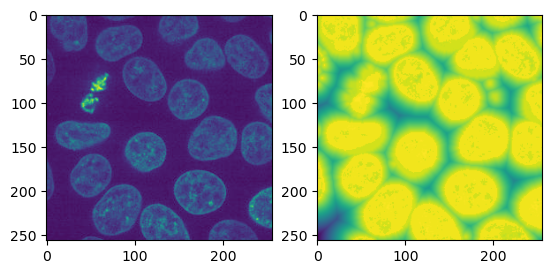

In [5]:
## set the following appropriately
IMG_DIR = "./images/"  ## dir containing images for a 3D example; all the images must be of the same dimension
volfile = "3d_img.npy"  ## the 3d image will be saved into this 3D numpy array file

# create a 3d stack from 2d images
if os.path.isdir(IMG_DIR):
    # load image files from a dir and stack into a 3D array of type float64
    input_files = os.path.join(IMG_DIR,"*.jpg")
    files = [f for f in glob.glob(input_files)]
    files.sort(key=lambda val : int(re.sub("\\D", "", val+"0")))
    img3d = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
else:
    ## create a dummy stack from a single 2d image
    img3d = np.dstack([rotate(img2d, 10*i) for i in range(8)])
    #img3d = skimage.util.img_as_float(cells3d()[:, 1, :, :]).transpose((1,2,0))  # requires pooch
#np.save(volfile,img3d.astype(np.float64))

# rescaleing
#img3d = skimage.transform.resize(img3d,(130,160,6))

## apply distance transform
img3d_dt = dt(img3d,signed=True)

fig,axs = plt.subplots(1,2)
axs[0].imshow(img3d[:,:,img3d.shape[-1]//2])
axs[1].imshow(img3d_dt[:,:,img3d_dt.shape[-1]//2])
print(img3d.shape, img3d.dtype, f"{np.min(img3d)}--{np.max(img3d)}")


In [ ]:
# 3D plot of slices
explore_slices(img3d)


Betti numbers:  [11226, 13762, 2893]
Betti numbers:  [6019, 13244, 6628]
elapsed_time:0.9759011268615723 sec


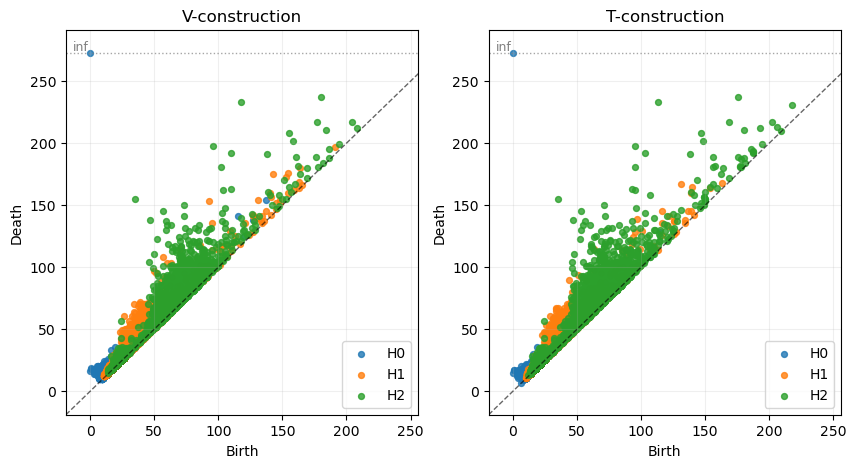

In [7]:
# 3D: compute PH for the V-construction of the original image (pixel value filtration)
start = time.time()
pd = cripser.compute_ph(img3d)
pds = cripser.group_by_dim(pd)
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# compute PH for the T-construction of the original image (pixel value filtration)
pdt = cripser.compute_ph(img3d, filtration="T")
pdst = cripser.group_by_dim(pdt)
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

print ("elapsed_time:{} sec".format(time.time() - start))
## plot persistent diagram
fig,axs = plt.subplots(1,2, figsize=(10,5))
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pd), ax=axs[0], title='V-construction')
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pdt), ax=axs[1], title='T-construction')


In [8]:
# compute PH for the T-construction by GUDHI
try:
    import gudhi
    start = time.time()
    gd = gudhi.CubicalComplex(vertices=img3d)
    #    gd.compute_persistence()
    res = gd.persistence(2,0) # coeff = 2
    print("Betti numbers (V): ", gd.persistent_betti_numbers(np.inf,-np.inf))
    gd = gudhi.CubicalComplex(top_dimensional_cells=img3d)
    res = gd.persistence(2,0) # coeff = 2
    print("Betti numbers (T): ", gd.persistent_betti_numbers(np.inf,-np.inf))
    print ("elapsed_time:{} sec".format(time.time() - start))
except ImportError:
    print("GUDHI is not installed.")


Betti numbers (V):  [11226, 13762, 2893, 0]
Betti numbers (T):  [6019, 13244, 6628, 0]
elapsed_time:3.2180588245391846 sec


Betti numbers:  [1879, 942, 144]
Betti numbers:  [1064, 949, 247]
elapsed_time:0.7386691570281982 sec


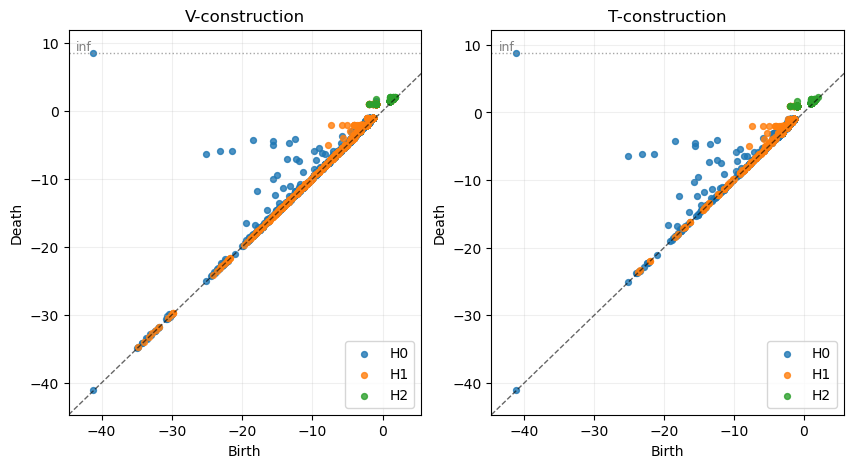

In [10]:
# 3D: compute PH for the V-construction of the distance transformed image
start = time.time()
pd = cripser.compute_ph(img3d_dt)
pds = cripser.group_by_dim(pd)
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# compute PH for the T-construction of the distance transformed image
pdt = cripser.compute_ph(img3d_dt, filtration="T")
pdst = cripser.group_by_dim(pdt)
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

print ("elapsed_time:{} sec".format(time.time() - start))
## plot persistent diagram
fig,axs = plt.subplots(1,2, figsize=(10,5))
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pd), ax=axs[0], title='V-construction')
cripser.plot_diagrams(cripser.to_gudhi_diagrams(pdt), ax=axs[1], title='T-construction')


In [11]:
# print some PH cycles
print("#0-cycle {}, #1-cycle {}, #2-cycle {}".format(len(pds[0]),len(pds[1]),len(pds[2])))
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]") # each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print(pds[0][:5])
print(pds[1][:5])
print(pds[2][:5])

#0-cycle 1879, #1-cycle 942, #2-cycle 144
[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[  0.         -41.15823125 -41.10960958 252.           0.
    5.         252.           0.           3.        ]
 [  0.         -34.9141805  -34.84250278 244.           8.
    0.         244.           7.           0.        ]
 [  0.         -34.84250278 -34.78505426 244.           8.
    5.         244.           8.           3.        ]
 [  0.         -34.23448554 -34.17601498 243.           9.
    5.         243.           9.           3.        ]
 [  0.         -34.3074336  -34.0881211  243.           9.
    0.         243.           8.           0.        ]]
[[  1.           1.41421356   1.73205081  91.          50.
    4.          91.          50.           3.        ]
 [  1.           1.41421356   1.73205081  91.          51.
    5.          92.          50.           5.        ]
 [  1.           1.41421356   1.73205081  13.         163.
    5.          13.         163.           4.        ]
 [  1.   

In [12]:
# check Alexander duality
pdt = cripser.compute_ph(img3d_dt, filtration="T")
pdt_reduced = pdt[ np.abs(pdt[:,1:3]).max(axis=1)<999999 ]
pdt_reduced =pdt_reduced[np.lexsort((pdt_reduced[:,0], pdt_reduced[:,2], pdt_reduced[:,1]))]

pdt2 = cripser.compute_ph(img3d_dt,embedded=True)
pdt2_reduced = pdt2[ np.abs(pdt2[:,1:3]).max(axis=1)<999999 ]
pdt2_reduced = pdt2_reduced[np.lexsort((pdt2_reduced[:,0], pdt2_reduced[:,1], pdt2_reduced[:,2]))[::-1]]

print("reduced Betti numbers shold be up side down: ",
      [np.sum(pdt_reduced[:,0] == i) for i in range(3)],[np.sum(pdt2_reduced[:,0] == i) for i in range(3)])

p1 = [pdt_reduced[pdt_reduced[:,0] == i, 1:3] for i in range(3)]
p2 = [pdt2_reduced[pdt2_reduced[:,0] == i, 1:3] for i in range(3)]

print("PH0 vs PH2", np.allclose(p1[0], -p2[2][:,[1,0]]))
print("PH1 vs PH1", np.allclose(p1[1], -p2[1][:,[1,0]]))
print("PH2 vs PH0", np.allclose(p1[2], -p2[0][:,[1,0]]))


reduced Betti numbers shold be up side down:  [np.int64(1063), np.int64(949), np.int64(247)] [np.int64(247), np.int64(949), np.int64(1063)]
PH0 vs PH2 True
PH1 vs PH1 True
PH2 vs PH0 True


In [19]:
## compute the density heatmap of cycles with specified birth and death ranges
def heat_map(img,pd,h=5,sigma=1,min_life = 10,max_life =255,min_birth = 0,max_birth = 255,dimension = 0,life_weighted=True):
    if len(img.shape)==2:
        mx,my=img.shape
        mz = 1
    else:
        mx,my,mz=img.shape

    selected_cycle = np.zeros((mx,my,mz))
    ppd = pd[pd[:,0] == dimension]
    ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
    ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
    ppd = ppd[min_birth < ppd[:,1]]
    ppd = ppd[ppd[:,1] < max_birth]
    w = 1
    for c in ppd:
        if life_weighted:
            w = c[2]-c[1]
        selected_cycle[int(c[3]),int(c[4]),int(c[5])] += w
    v = convolve(np.squeeze(selected_cycle),gaussian(h,sigma))
    return(v)

def gaussian(h,sigma):
    x = np.arange(-h,h,1)
    y = np.arange(-h,h,1)
    z = np.arange(-h,h,1)
    xx, yy, zz = np.meshgrid(x,y,z)
    return(np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2)).astype(np.float32))


In [20]:
# Visualise the cycle density heatmap
pd = cripser.compute_ph(img3d)
vol = heat_map(img3d,pd,dimension=2)
explore_slices(vol,cmap='jet')

interactive(children=(IntSlider(value=3, description='plane', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.explore_slices.<locals>.display_slice(plane=3)>

### 1D example

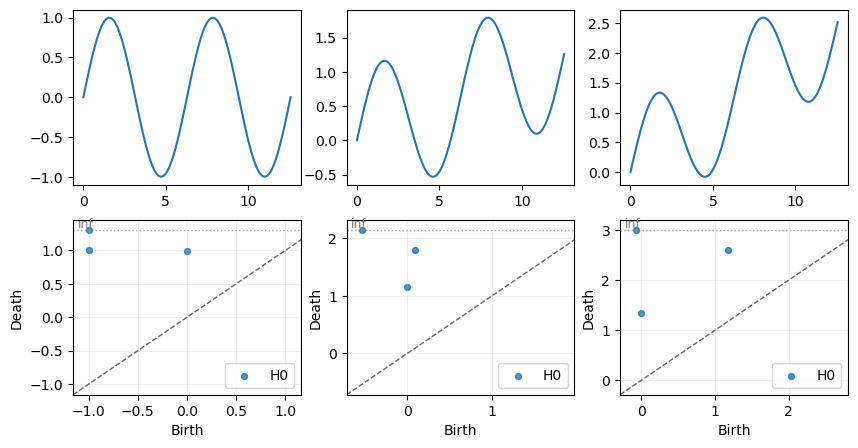

In [13]:
## 1D example (scalar timeseries)
#%matplotlib inline
x = np.linspace(0,4*np.pi,100)
fig,axs = plt.subplots(2,3,figsize=(10,5))

for i in range(3):
    img1d = np.sin(x)+i*0.1*x
    axs[0,i].plot(x,img1d)
    pd = cripser.compute_ph(img1d)
    cripser.plot_diagrams(cripser.to_gudhi_diagrams(pd),ax=axs[1,i])

# Differentiable Cubical PH

Topology-driven optimisation using torch.


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, update_display
import cripser

np.random.seed(0)
torch.manual_seed(0)
_INF_CUTOFF = np.finfo(np.float64).max / 2.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
print('torch:', torch.__version__)

device: cpu
torch: 2.10.0


In [19]:
# Parameters
n_iterations = 1000
learning_rate = 1e-2
noise = 0.0
maxdim = 1
filtration = 'V'

# Generate synthetic image
n, m = 30, 30
y, x = np.mgrid[-6:6:n*1j, -3:3:m*1j]
X_org = np.cos(2 * x) - np.sin(2 * y) + 0.1 * x
X_org = X_org + np.random.normal(scale=noise, size=X_org.shape)

# Set X as a learnable parameter
X = torch.tensor(X_org, dtype=torch.float32, device=device, requires_grad=True)
X = torch.nn.Parameter(X)

optimizer = torch.optim.Adam([X], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25)

losses = {'epoch': [], 'loss': [], 'lr': []}

In [20]:
progress = tqdm(range(n_iterations))
for i in progress:
    ph = cripser.compute_ph_torch(X, filtration=filtration, maxdim=maxdim)
    life_h1 = cripser.finite_lifetimes(ph, dim=1)
    loss = -life_h1.sum()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step(loss.item())

    losses['epoch'].append(i + 1)
    losses['loss'].append(float(loss.item()))
    losses['lr'].append(float(optimizer.param_groups[0]['lr']))
    progress.set_postfix(loss=f"{loss.item():.8f}", h1_count=int(life_h1.numel()))

X_opt = X.detach().cpu().numpy()
plt.close(fig)


  0%|          | 0/1000 [00:00<?, ?it/s]

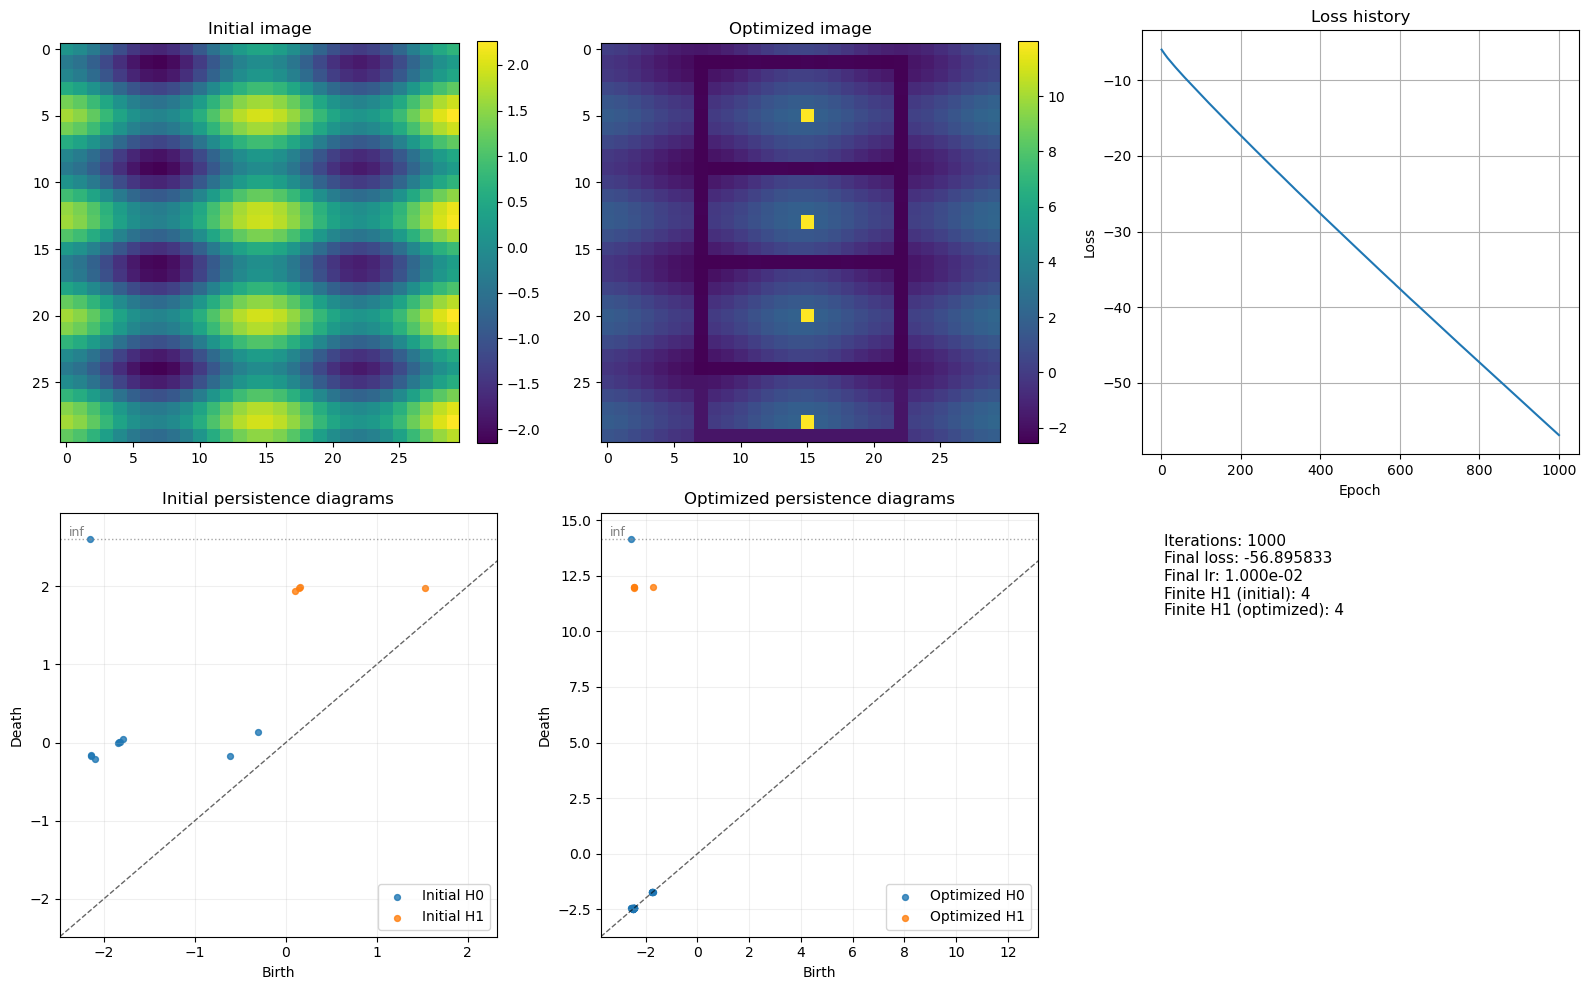

In [21]:
def compute_diagrams_np(arr, maxdim=1, filtration='V'):
    ph = cripser.compute_ph(
        np.asarray(arr, dtype=np.float64),
        maxdim=maxdim,
        filtration=filtration,
    )
    ph = np.asarray(ph, dtype=np.float64)

    if ph.size == 0:
        return [np.empty((0, 2), dtype=np.float64) for _ in range(maxdim + 1)]

    deaths = ph[:, 2].copy()
    deaths[deaths >= _INF_CUTOFF] = np.inf
    dims = ph[:, 0].astype(np.int64, copy=False)

    diagrams = []
    for k in range(maxdim + 1):
        sel = dims == k
        diagrams.append(np.column_stack((ph[sel, 1], deaths[sel])))
    return diagrams

PH_org = compute_diagrams_np(X_org, maxdim=1, filtration=filtration)
PH_opt = compute_diagrams_np(X_opt, maxdim=1, filtration=filtration)

fig, axs = plt.subplots(2, 3, figsize=(16, 10))

im0 = axs[0, 0].imshow(X_org, cmap='viridis')
axs[0, 0].set_title('Initial image')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

im1 = axs[0, 1].imshow(X_opt, cmap='viridis')
axs[0, 1].set_title('Optimized image')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

axs[0, 2].plot(losses['epoch'], losses['loss'])
axs[0, 2].set_title('Loss history')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].grid(True)

cripser.plot_diagrams(PH_org, labels=['Initial H0', 'Initial H1'], ax=axs[1, 0])
axs[1, 0].set_title('Initial persistence diagrams')

cripser.plot_diagrams(PH_opt, labels=['Optimized H0', 'Optimized H1'], ax=axs[1, 1])
axs[1, 1].set_title('Optimized persistence diagrams')

axs[1, 2].axis('off')
axs[1, 2].text(
    0.05,
    0.95,
    f'Iterations: {n_iterations}\n'
    f'Final loss: {losses["loss"][-1]:.6f}\n'
    f'Final lr: {losses["lr"][-1]:.3e}\n'
    f'Finite H1 (initial): {np.isfinite(PH_org[1][:, 1]).sum()}\n'
    f'Finite H1 (optimized): {np.isfinite(PH_opt[1][:, 1]).sum()}',
    va='top',
    fontsize=11,
)

plt.tight_layout()
plt.show()
